In [1]:
from dcase_evaluator import DCASEEvaluator
from models.audiosep import AudioSep
from models.one_peace_encoder import ONE_PEACE_Encoder

import argparse
import os
from utils import parse_yaml, load_ss_model
import torch
import numpy as np

import librosa
import pandas as pd
import soundfile as sf
import scipy.io.wavfile as wf
from scipy.io import wavfile
from scipy.signal import spectrogram
from tqdm import tqdm
import matplotlib.pyplot as plt

/fs/nexus-scratch/vla/micromamba/envs/LASS/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/fs/nexus-scratch/vla/micromamba/envs/LASS/lib/python3.9/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/nfshomes/vla/lass-final-project/models/CLAP/open_clip/factory.py:55: FutureWarning: You a

In [23]:
# Generate and plot the spectrogram
def plot_spectrograms(source, sep_segment, sample_rate):
    # Load the audio file
    # sample_rate, data = load_wav(file_path)
    
    # Generate spectrogram for mixture source audio
    frequencies, times, Sxx = spectrogram(source, fs=sample_rate)
    
    # Plot spectrogram
    plt.figure(figsize=(10, 6))
    source_cmesh = plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud', cmap = 'plasma')
    plt.colorbar(label='Power (dB)')
    plt.title('Mixture')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.tight_layout()
    plt.show()

    # return source_cmesh

    vmax = source_cmesh.colorbar.norm.vmax
    vmin = source_cmesh.colorbar.norm.vmin

    # Generate spectrogram for mixture source audio
    frequencies, times, Sxx = spectrogram(sep_segment, fs=sample_rate)
    
    # Plot spectrogram
    plt.figure(figsize=(10, 6))
    plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud', cmap = 'plasma',
                   vmin=vmin, vmax=vmax)
    
    plt.colorbar(label='Power (dB)')
    plt.title('Separation Result')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.tight_layout()
    plt.show()

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
config_yaml = 'config/audiosep_onepeace.yaml'
encoder_checkpoint_path = '/fs/nexus-scratch/vla/finetune_al_retrieval.pt'

# NOTE: best checkpoint on validation set
ssnet_checkpoint_path = '/fs/nexus-scratch/vla/checkpoints/train/audiosep_onepeace,devices=1/step=140000.ckpt'
sampling_rate=1600
configs = parse_yaml(config_yaml)

# ONE_PEACE modelhub expects some paths to be relative to this dir
os.chdir('ONE-PEACE/')
# TODO:path in shared scratch dir for now..., move to class project dir whenever we get that
query_encoder = ONE_PEACE_Encoder(pretrained_path=encoder_checkpoint_path)
os.chdir('..')

# put ONE-PEACE model in eval model (probably unecessary)
query_encoder.model.model.eval()

pl_model = load_ss_model(
    configs=configs,
    checkpoint_path=ssnet_checkpoint_path,
    query_encoder=query_encoder
).to(device)

/fs/nexus-scratch/vla/micromamba/envs/LASS/lib/python3.9/site-packages/fairseq/checkpoint_utils.py:317: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(f, m

## REAL Evaluation (Test) Set

In [4]:
eval_csv = 'lass_real_evaluation.csv'
dict_eval = pd.read_csv(eval_csv).set_index('file_name').to_dict()['query']
output_dir = 'lass_evaluation_real_output'
audio_dir = 'lass_evaluation_real'

In [29]:
test_samples = [i for i in range(200)]
filenames = [os.path.join(f'test-real-case-{s}.wav') for s in test_samples]

gather = []
with torch.no_grad():
    for i, filename in enumerate(tqdm(filenames)):
        
        # load audio from test set
        input_path = os.path.join(audio_dir, filename)
        source, fs = librosa.load(input_path, sr=sampling_rate, mono=True)

        # compute text embedding with ONE-PEACE query encoder
        conditions = pl_model.query_encoder.get_query_embed(
                        modality='text',
                        text=[dict_eval[filename]],
                        device=device 
        )

        input_dict = {
                        "mixture": torch.Tensor(source)[None, None, :].to(device),
                        "condition": conditions,
                    } 

        # output audio
        sep_segment = pl_model.ss_model(input_dict)["waveform"]

        # TODO: compute ONE-PEACE embedding on sep_segment and dot w/ conditions for comparison in embedding space
        # sep_segment_embd = pl_model.query_encoder.model
        # sep_segment: (batch_size=1, channels_num=1, segment_samples)
        sep_segment = sep_segment.squeeze(0).squeeze(0).data.cpu().numpy()


        # write out .wav file
        output_path = os.path.join(output_dir, filename)
        # wf.write(output_path, sampling_rate, sep_segment)

        similarities = dict(
            filename = filename
        )

        # COMPUTE SIMILARITIES
        src_audios, audio_padding_masks = pl_model.query_encoder.model.process_audio([input_path])
        audio_features = pl_model.query_encoder.model.extract_audio_features(src_audios, audio_padding_masks)
        input_similarity = conditions @ audio_features.T
        similarities['input_similarity'] = input_similarity.squeeze(0).cpu().numpy()[0]
        # print(f'Text Prompt - Mixed Audio Input Similarity: {input_similarity}')

        src_audios, audio_padding_masks = pl_model.query_encoder.model.process_audio([output_path])
        audio_features = pl_model.query_encoder.model.extract_audio_features(src_audios, audio_padding_masks)
        output_similarity = conditions @ audio_features.T
        similarities['output_similarity'] = output_similarity.squeeze(0).cpu().numpy()[0]
        # print(f'Text Prompt - Seperated Audio Output Similarity: {output_similarity}')

        gather.append(similarities)


200it [01:16,  2.61it/s]


In [24]:
def plot_spectrogram_by_idx(idx, filenames):

    filename = filenames[idx]

    with torch.no_grad():
        # load audio from test set
        input_path = os.path.join(audio_dir, filename)
        source, fs = librosa.load(input_path, sr=sampling_rate, mono=True)


        # compute text embedding with ONE-PEACE query encoder
        conditions = pl_model.query_encoder.get_query_embed(
                        modality='text',
                        text=[dict_eval[filename]],
                        device=device 
        )

        input_dict = {
                        "mixture": torch.Tensor(source)[None, None, :].to(device),
                        "condition": conditions,
                    } 

        # output audio
        sep_segment = pl_model.ss_model(input_dict)["waveform"]

        # TODO: compute ONE-PEACE embedding on sep_segment and dot w/ conditions for comparison in embedding space
        # sep_segment_embd = pl_model.query_encoder.model
        # sep_segment: (batch_size=1, channels_num=1, segment_samples)
        sep_segment = sep_segment.squeeze(0).squeeze(0).data.cpu().numpy()

        plot_spectrograms(source, sep_segment, sampling_rate)

        

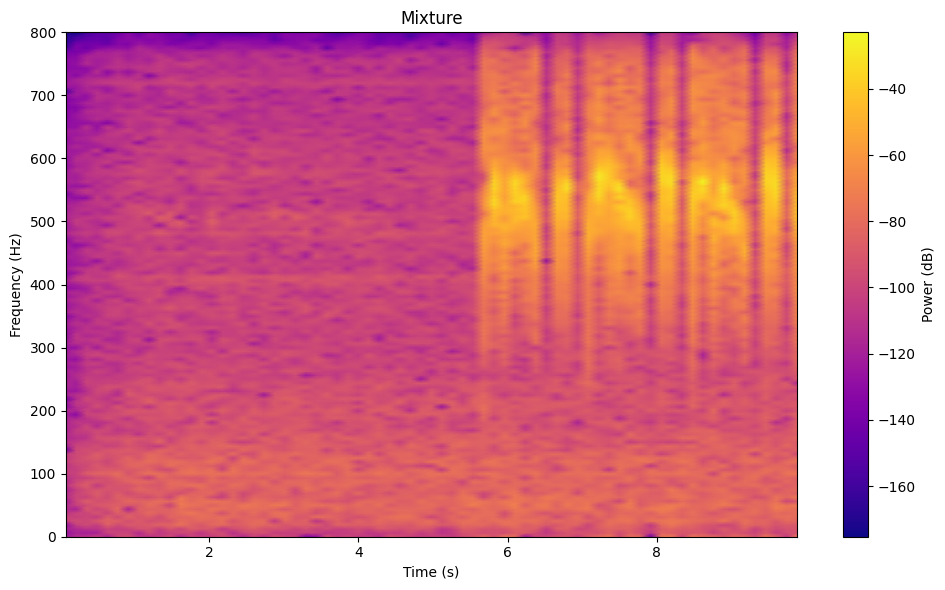

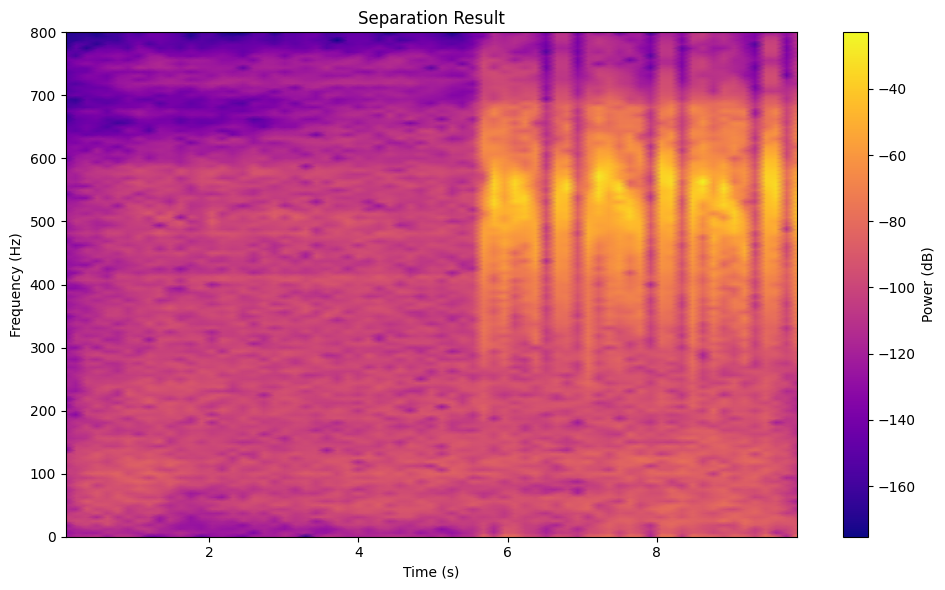

In [25]:
plot_spectrogram_by_idx(28, filenames)

In [35]:
df = pd.DataFrame(gather)
df['delta_similarity'] = df.output_similarity - df.input_similarity
df['text_prompt'] =  [dict_eval[row_dict['filename']] for row_dict in df.to_dict('records')]

pd.set_option('display.max_colwidth', 255)
df[:5]

,filename,input_similarity,output_similarity,delta_similarity,text_prompt
0,test-real-case-0.wav,0.353481,0.174944,-0.178537,"the fire crackles in the wind, creating a rhythmic and soothing sound."
1,test-real-case-1.wav,0.408589,0.104871,-0.303718,the fire is making crackling sounds at home.
2,test-real-case-2.wav,0.299390,0.052827,-0.246563,the wind chimes are making a crisp and sweet sound.
3,test-real-case-3.wav,0.306068,0.057903,-0.248165,the wind chime is ringing continuously.
4,test-real-case-4.wav,0.186258,0.071553,-0.114705,a group of people are talking with each other.


In [36]:
# Top 10 increase in similarity
df.sort_values(by = 'delta_similarity', ascending=False)[:20]

,filename,input_similarity,output_similarity,delta_similarity,text_prompt
89,test-real-case-89.wav,0.032961,0.252459,0.219498,a man is delivering a speech passionately and loudly.
186,test-real-case-186.wav,0.040551,0.243610,0.203059,"a vehicle is speeding by, creating a deafening din."
142,test-real-case-142.wav,0.096658,0.281705,0.185047,the sound of human voices keeps coming.
12,test-real-case-12.wav,-0.033668,0.120089,0.153757,the woman is speaking in a distance.
68,test-real-case-68.wav,0.089508,0.226485,0.136977,someone is beating the drum continuously.
69,test-real-case-69.wav,0.150574,0.281169,0.130595,someone is playing drum kit to make rhythmic and dynamic sounds.
52,test-real-case-52.wav,0.210967,0.335514,0.124547,the waves are churning incessantly in the ocean.
118,test-real-case-118.wav,0.189310,0.297990,0.108680,"in a noisy environment, the birds are chirping incessantly."
87,test-real-case-87.wav,0.226570,0.328521,0.101951,blowing winds came from afar.
187,test-real-case-187.wav,-0.061375,0.023337,0.084712,the birds are chirping and the ducks are quacking.


In [37]:
# Top 10 increase in similarity
df.sort_values(by = 'output_similarity', ascending=False)[:20]

,filename,input_similarity,output_similarity,delta_similarity,text_prompt
29,test-real-case-29.wav,0.487257,0.471914,-0.015343,a cuckoo is singing loudly in the forest.
28,test-real-case-28.wav,0.468044,0.466134,-0.001910,a cuckoo is singing happily in the forest.
20,test-real-case-20.wav,0.403465,0.461346,0.057881,thunder is raging and rumbling from afar.
55,test-real-case-55.wav,0.484623,0.429576,-0.055047,someone is playing the drum to make rhythmic and dynamic sounds.
54,test-real-case-54.wav,0.490684,0.424605,-0.066079,"someone is beating the drum, making a wonderful sound."
195,test-real-case-195.wav,0.449648,0.358604,-0.091044,the clear chirping of cuckoos keeps coming.
176,test-real-case-176.wav,0.294209,0.351306,0.057097,the water is dribbling and emitting echoes in the room.
157,test-real-case-157.wav,0.599794,0.350310,-0.249484,the thunder is heavily rumbling.
71,test-real-case-71.wav,0.281877,0.346803,0.064926,the waves are beating against the shore.
76,test-real-case-76.wav,0.435010,0.346252,-0.088758,the train horn is sounding a honk sound.


In [38]:
df.sort_values(by = 'input_similarity', ascending=False)[:20]

,filename,input_similarity,output_similarity,delta_similarity,text_prompt
157,test-real-case-157.wav,0.599794,0.350310,-0.249484,the thunder is heavily rumbling.
144,test-real-case-144.wav,0.580971,0.236987,-0.343983,the persistent chirping of crickets in the grass intensifies the natural harmony of the night.
82,test-real-case-82.wav,0.566679,0.177873,-0.388806,"the crickets in the grass are making a constant buzzing sound, adding to the evening's natural harmony."
145,test-real-case-145.wav,0.559296,0.164778,-0.394518,lots of crickets are chirping together in the grass.
95,test-real-case-95.wav,0.556390,0.327705,-0.228685,the dog is barking loudly.
119,test-real-case-119.wav,0.549892,0.162734,-0.387158,a rooster is crowing at dawn.
72,test-real-case-72.wav,0.547434,0.198144,-0.349290,"with the blowing of wind, the wind chimes are making a crisp and sweet sound."
147,test-real-case-147.wav,0.536872,0.321626,-0.215246,the wind chimes keep swinging and making a clear and crisp sound.
139,test-real-case-139.wav,0.535695,0.107708,-0.427987,the crow keeps making noise.
146,test-real-case-146.wav,0.535385,0.324114,-0.211271,there are plenty of wind chimes clashing together.
